# HW3-B. Defining an Encoder-Decoder model

## About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (06/03/2024)

**Requirements:**
- Python 3
- Matplotlib
- Numpy
- Pandas
- Torch
- Torchmetrics

In [16]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pandas
import pandas as pd
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# Helper functions (additional file)
from helper_functions import *

<div class="alert alert-block alert-info">
<b>An important note: While usually not advised, you might want to run the code for this homework using CPU only. <br>
It remains possible, however, to use GPU, but we would advise against it, until we have been able to clarify the reason for bugs (most likely some CUDA reason). </b> 
</div> 

In [17]:
# For windows/linux will try CUDA, for Apple devices will try MPS 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 0. Dataset and Dataloaders from earlier

We start by loading our dataset from the Excel file, and reuse our Dataset and Dataloader objects from HW3-A.

In [18]:
# Load dataset from file
excel_file_path = 'data/weather_data_1hr.csv'
times, temperatures = load_dataset(excel_file_path)

In [19]:
# class CustomDataset(Dataset):
#     # Reuse your code from Notebook 3A

class CustomDataset(Dataset):
    def __init__(self, times, temperatures, n_inputs, n_outputs):
        self.times = times
        self.temperatures = temperatures
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.inputs = []
        self.outputs = []
        self.define_samples()


    def define_samples(self):
        # Define all inputs
        for i in range(len(self.times) - self.n_inputs - self.n_outputs):
            # Last input not included
            next_input = self.temperatures[i:(i + self.n_inputs)]
            # Output
            next_output = self.temperatures[(i + self.n_inputs):(i + self.n_inputs + self.n_outputs)]
            self.inputs.append(next_input)
            self.outputs.append(next_output)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # Select samples corresponding to the different inputs
        # and outputs we have created with the define_samples() function,
        # and convert them to PyTorch tensors
        x = torch.tensor(self.inputs[idx], dtype=torch.float32)
        y = torch.tensor(self.outputs[idx], dtype=torch.float32)
        return x, y

In [20]:
# Create our PyTorch Dataset object from the class above
n_inputs = 168
n_outputs = 24
pt_dataset = CustomDataset(times, temperatures, n_inputs, n_outputs)

In [21]:
# Define batch size
batch_size = 128

#random # generator 
generator = torch.Generator(device=device)
# Create DataLoader object
pt_dataloader = DataLoader(pt_dataset, batch_size=batch_size, shuffle=True, generator=generator)

print(f"Length of dataset: {len(pt_dataset)}")

Length of dataset: 1272


## 1. Step 1: Designing an Encoder model

We propose to approach this task, by using and Encoder-Decoder model of some sort. Both the Encoder and Decoder parts of the model will consist of a simple LSTM.

**Question 6:** What is a Seq2Seq model, and how does it relate to Encoder-Decoder models?

**ANSWER 6:** A Seq2Seq model is a special type of many-to-many model. Its key difference relies in separating the analysis of the input sequence and the production of an output after seeing all inputs. This is often handled by two different part of a larger neural network, which is where it becomes related to the Encoder-Decoder models. In general, the first part of a Seq2Seq model will focus on analysing the input sequence, eventually producing a final memory vector output after having seen all inputs. This is the encoder part of the model. Furthermore, in general the second part of the model will focus on analysing the produced encoding vector and producing a sequence of some sort as output. This is the decoder part of the model. 

We want to implement the LSTM architecture drawn below. Its objective is to receives entire $ x(t), x(t+1), ..., x(t+167) $, 168 input points, and learn the dynamics of the data, in the hopes that we will later be able to use this information for future predictions.

<img title="Our Encoder Architecture" alt="Our Encoder Architecture" src="./images/Picture1.png" width="60%">

Given the LSTM Architecture above, answer the questions below.

**Question 7:** This encoder seems to receive all inputs present in the first tensor coming from the Dataloader object, which includes n_inputs elements. This LSTM could then produce 168 outputs, but for some reason, they are not used or even returned. What is the reason for this omission? What information in contained in the final memory vector that will come out of this encoder model?

**ANSWER 7:** 
Referencing the architecture above, the encoder model's intermediary outputs (output_0 to output_167) are not used because they each represent a memory vector that is only relevant for that specific point of time or intermediate state. However, this is not what we are interested in, instead we want a a final memory vector output after having seen and analysed all 168 inputs, so we can capture the inherent dependece on time steps for the whole week. The final memory vector contains a compressed representation of the 168 hours of temperature data (prior to time, t). The vector likely captures the the temporal patterns and trends. 

We want our Encoder model to be represented by the EncoderRNN object, whose class prototype is shown below.

**Question 8:** There are a few Nones to be replaced in the code below. Please show your code in your report after you have figured out the correct EncoderRNN class.

In [23]:
#ANSWER FOR QUESTION 8
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = False)

    def forward(self, inputs):
        output, hidden = self.lstm(inputs)
        
        # Return the final hidden state to be used by the decoder
        return hidden

In [24]:
# Defining our EncoderRNN model
hidden_size = 64
encoder_model = EncoderLSTM(1, hidden_size)
print(encoder_model)

EncoderLSTM(
  (lstm): LSTM(1, 64)
)


**Question 9:** Consider the cell below. What is the shape of *vec1\[0\]* and *vec2\[0\]*? What information do they contain?

**ANSWER 9:** 

shape of vec1[0]: torch.Size([128, 64])

Information Contained: vec1[0] is the hidden vector which represents the final state of the LSTM for all 128 samples in the batch, capturing information from the last time step. 

shape of vec2[0]: torch.Size([128, 64])

Information Contained: vec2[0] is the cell vector which represents the final cell state of the LSTM for all 128 samples in the batch, capturing information from the last time step. 

In [25]:
# Testing our EncoderRNN model
inputs, _ = next(iter(pt_dataloader))  #get the data 
inputs = inputs.unsqueeze(-1).permute(1, 0, 2) #reshape the data to be (seq_len, batch_size, input_size)
# inputs = inputs.unsqueeze(-1) # Add a new dimension for input size

print(inputs.shape)
encoder_out = encoder_model(inputs[-1:]) #taking the last time step of the sequence and passing it to the encoder
vec1, vec2 = encoder_out # final hidden state and cell state
print(vec1[0])
print(f"shape of vec1[0]: {vec1[0].shape}")
print(vec2[0])
print(f"shape of vec2[0]: {vec2[0].shape}")

torch.Size([168, 128, 1])
tensor([[ 0.0196, -0.4595, -0.1366,  ...,  0.2022,  0.0165,  0.0849],
        [ 0.0183, -0.5478, -0.1380,  ...,  0.2056,  0.0168,  0.0643],
        [ 0.0197, -0.4327, -0.1347,  ...,  0.1984,  0.0157,  0.0895],
        ...,
        [ 0.0123, -0.6720, -0.1176,  ...,  0.1777,  0.0098,  0.0253],
        [ 0.0194, -0.4844, -0.1377,  ...,  0.2046,  0.0170,  0.0799],
        [ 0.0149, -0.6348, -0.1281,  ...,  0.1919,  0.0129,  0.0376]],
       grad_fn=<SelectBackward0>)
shape of vec1[0]: torch.Size([128, 64])
tensor([[ 0.0446, -0.6488, -0.2572,  ...,  0.6308,  0.0804,  0.5882],
        [ 0.0440, -0.7439, -0.2500,  ...,  0.7340,  0.1220,  0.6858],
        [ 0.0442, -0.6189, -0.2561,  ...,  0.5978,  0.0696,  0.5585],
        ...,
        [ 0.0344, -0.8759, -0.1939,  ...,  0.8726,  0.2119,  0.8300],
        [ 0.0447, -0.6761, -0.2570,  ...,  0.6606,  0.0910,  0.6156],
        [ 0.0391, -0.8354, -0.2192,  ...,  0.8307,  0.1786,  0.7847]],
       grad_fn=<SelectBackward0>

## 2. Step 2: Designing a Decoder model

Our next step is to produce a decoder model. It will receive a certain memory vector as its memory starting point. It may also receive 24 inputs denoted *in1*, ... and *in24*. It will then attempt to produce 24 outputs denoted *out1*, ... and *out24*.

We aim to design the Decoder architecture which could supporting both auto-regressive and non-auto-regressive decoding, according to if we provide the target values or not. (Normally we would provide the target values during training which is called teacher-forcing and will not provide target values during predicting).
Consider the architecture drawn below and answer the following questions.

As you can see, it will receive certain input values $in_k$ and will attempt to predict a value $out_k$, with k in $ [1, 24] $.

<img title="Our Decoder Architecture" alt="Our Decoder Architecture" src="./images/Picture2.png" width="60%" >
<img title="Our Decoder Architecture" alt="Our Decoder Architecture" src="./images/Picture3.png" width="60%" >


**Question 10:** Assuming that the encoder has seen the inputs $ x(t), x(t+1), ... x(t+167) $, what should we use as a memory vector to play the role of the memory starting point for the decoder?

**Question 11:** We will use a Decoder that is auto-regressive when not given *target*. What does that mean for the input and output values of our Decoder LSTM-based model?

**Question 12:** Assuming that the encoder has seen the inputs corresponding to the sample with index $ t $, i.e. $ x(t), x(t+1), ... x(t+167) $, which values should we use in place for $in_k$? Remember Q11, we are planning to use an auto-regressive decoder here.

**Question 13:** Assuming that the encoder has seen the inputs corresponding to the sample with index $ t $, i.e. $ x(t), x(t+1), ... x(t+167) $, what are the target values should we are trying to match with our predictions in place for $out_k$?

**Question 14:** What is then the purpose and the expected use for the Linear layer in self.linear? Why there is a for loop in the forward method?

**Question 15:** Having figured out the questions in Q10-14, can you figure what to use in place of the Nones in the code for the DecoderRNN below? Show your final code in your report.

**ANSWER 10:** 

We should use the final hidden state and final state produced by the encoder, which it outputs adter processing all the inputs $ x(t), x(t+1), ... x(t+167) $. 

**ANSWER 11:** 

Referencing the architecture diagram above, the input into the LSTM of the auto-regressive decoder would be taken from the immediate output of the previous timestamp. To be more specific, at the start the input would be the the final vectors produced by the encoder, afterwhich at each step (from 1 to 24), the model produces an output, which is its prediction of mean temperature for that hour at that timestep. 

**ANSWER 12:** 

Referencing the architecture diagram above, for k = 0, we should use the $ in_0 = x(t+167) $ produced by the encoder. For subsequent k, we should use $in_k = output_{k-1}$.

**ANSWER 13:** 
With reference to the task description in HW3-A, we are trying to predict the next 24 values (a day) , i.e. $ x(t+168), x(t+168+1), ..., x(t+168+23) $.

**ANSWER 14:** 
Given the task at hand, the LSTM hidden states $(y_1, y_2, .., y_24)$ are high-dimensional vectors, but the final prediction we want is a single scalar: the temperature for a specific hour. Thus, the linear layer allows for us to generate an output with the desired output space = 1.  

Referecing the code below, the for loop in the forward method is to generate the output sequence auto-regressively. For each time step, the decoder produces a single output of the sequence. Using a loop, that output is fed back as the input to be used by the decoder to generate the nest output of the sequence for the next time step. 

In [26]:
#ANSWER FOR QUESTION 15
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderLSTM, self).__init__()
        self.output_size = output_size
        self.lstm = nn.LSTM(output_size, hidden_size, batch_first = False)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, output_length, target=None):
        outputs = []
        decoder_input = x
        for i in range(output_length):
            # Generate one time step prediction
            # Feed the current prediction as the next input
            decoder_input, hidden = self.lstm(decoder_input, hidden)
            decoder_input = self.linear(decoder_input)
            outputs.append(decoder_input)
            if target is not None:
                decoder_input = target[i].unsqueeze(0)
        return torch.cat(outputs, dim = 0)

In [27]:
# Defining our DecoderRNN model
decoder_model = DecoderLSTM(hidden_size = hidden_size, output_size = 1)
print(decoder_model)

DecoderLSTM(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


**Question 16:** Consider the cell below. What should the final size of the *decoder_out* tensor be?


**ANSWER 16:** Final size of the *decoder_out* = torch.Size([24, 128, 1])

In [28]:
# Testing our DecoderRNN model
inputs, outputs = next(iter(pt_dataloader))
inputs = inputs.unsqueeze(-1).permute(1, 0, 2)

encoder_out = encoder_model(inputs[:-1])
decoder_out = decoder_model(inputs[-1:], encoder_out, n_outputs)
print(decoder_out.shape)

torch.Size([24, 128, 1])


## Step 3: Assembling everything into a Seq2Seq model.

Our final objective is to assemble both our encoder model and decoder model into a Seq2Seq model, following the architecture drawn below.

<img title="Our Seq2Seq Architecture" alt="Our Seq2Seq Architecture" src="./images/Picture4.png" width="60%">

**Question 17:** Why have we preferred to use a Decoder-Encoder architecture, instead of a single LSTM that would receive 168 inputs, produce 24 outputs, and would only compare the final 24 predicted values to the ground truth in our dataset?


**Question 18:** Having figured out the models in EncoderRNN and DecoderRNN, can you now figure out the missing code in the cell below? Show it in your report.

**ANSWER 17:**

Our auto-regressive seq-2-seq model is better able to learn sequential uncertainty and time-step dependencies in outputs. Autoregressive models generate output one step at a time, which each new prediction influenced by the previous one. This is especially beneficial for learning temporal weather patterns as often there might be underlying interconnected weather features that influence the temperature between days, especially for changes between season. So, if there are any temporal drifts or uncertainty between the hours, the decoder can learn to model step by step. 

Whereas, in a vanilla LSTM, you have a single model trying to understand the context and generating a forecast based only on its internal state, where errors can accumulate quicly across steps, hurting the model's accuracy & ability to generalise well. 


In [29]:
#ANSWER FOR QUESTION 18

class Seq2Seq(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Seq2Seq, self).__init__()
        self.output_length = output_size
        self.encoder = EncoderLSTM(1, hidden_size)
        self.decoder = DecoderLSTM(hidden_size, 1)

    def forward(self, inputs, outputs = None):
        hidden = self.encoder(inputs)
        decoder_input = inputs[-1:]
        output = self.decoder(decoder_input, hidden, self.output_length, target = outputs)
        return output

In [30]:
# Defining our Seq2Seq model
seq2seq_model = Seq2Seq(hidden_size = hidden_size, \
                        output_size = n_outputs)
print(seq2seq_model)

Seq2Seq(
  (encoder): EncoderLSTM(
    (lstm): LSTM(1, 64)
  )
  (decoder): DecoderLSTM(
    (lstm): LSTM(1, 64)
    (linear): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [31]:
# Testing our Seq2Seq model
seq2seq_model = Seq2Seq(hidden_size = hidden_size, \
                        output_size = n_outputs)

inputs, outputs = next(iter(pt_dataloader))
inputs = inputs.unsqueeze(-1).permute(1, 0, 2)
outputs = outputs.unsqueeze(-1).permute(1, 0, 2)
print(inputs.shape, outputs.shape)

seq2seq_out = seq2seq_model(inputs)
print(seq2seq_out.shape)

torch.Size([168, 128, 1]) torch.Size([24, 128, 1])
torch.Size([24, 128, 1])


## Step 4: Finally, training and evaluating our Seq2Seq model

**Question 19:** Given your understanding of the task, which (very simple) loss function should we use in our trainer function? Show your updated code in your report.

In [34]:
#ANSWER FOR QUESTION 19

def train(dataloader, model, num_epochs, learning_rate):
    # Set the model to training mode
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, outputs in dataloader:
            inputs = inputs.to(device)
            outputs = outputs.to(device)
            inputs = inputs.unsqueeze(-1).permute(1, 0, 2)
            outputs = outputs.unsqueeze(-1).permute(1, 0, 2)
            # Clear previous gradients
            optimizer.zero_grad()
            # Forward pass
            pred = model(inputs, outputs)
            # Calculate loss
            loss = criterion(pred, outputs)
            total_loss += loss.item()
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Print total loss every few epochs
        if epoch % 25 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Avg Loss: {total_loss / len(dataloader)}')

Having figure out the correct models and trainer function, you may not use the celml below. It will train the model from scratch, on 50 iterations and will show you the amount of time take to train this model. This is just information to let you know how long the full training loop (in the next cell), might take on your machine!

In [33]:
# Training the model
hidden_size = 64
seq2seq_model = Seq2Seq(hidden_size = hidden_size, \
                        output_size = n_outputs).to(device)
%timeit -r 1 -n 1 train(dataloader = pt_dataloader, model = seq2seq_model, num_epochs = 51, learning_rate = 1e-3)

Epoch 1/51, Avg Loss: 388.93186645507814
Epoch 26/51, Avg Loss: 22.989704132080078
Epoch 51/51, Avg Loss: 6.24815559387207
34 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
# # Training the model
# hidden_size = 64
# seq2seq_model = Seq2Seq(hidden_size = hidden_size, \
#                         output_size = n_outputs).to(device)
# %timeit -r 1 -n 1 train(dataloader = pt_dataloader, model = seq2seq_model, num_epochs = 51, learning_rate = 1e-3)

Epoch 1/51, Avg Loss: 375.85137329101565
Epoch 26/51, Avg Loss: 24.055384826660156
Epoch 51/51, Avg Loss: 6.465337657928467
8.24 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [40]:
# This was used to save a starting point for the next cell, do not run.
torch.save(seq2seq_model.state_dict(), 'seq2seq_model_start.pth')

**Question 20:** It seems the loss values we are seeing when using the model with randomly initialized parameters is very high. While it seems to decrease, it seems lots of iterations will be needed. The next cell suggests to run the training loop, but initialize the weights of the model using values in the *seq2seq_model_start.pth* file, presumably coming from another roughly similar model, trained on a different but similar task. This is done in an attempt to help the model train better and faster. Under which name is this concept known in Deep Learning?

**ANSWER 20:** 
Transfer Learning


In [41]:
# Training the model
hidden_size = 64
seq2seq_model = Seq2Seq(hidden_size = hidden_size, \
                        output_size = n_outputs).to(device)
# Start from given parameters to make training easier
seq2seq_model.load_state_dict(torch.load('seq2seq_model_start.pth'))
%timeit -r 1 -n 1 train(dataloader = pt_dataloader, model = seq2seq_model, num_epochs = 1051, learning_rate = 1e-3)

Epoch 1/1051, Avg Loss: 364.38490600585936
Epoch 26/1051, Avg Loss: 22.940870475769042
Epoch 51/1051, Avg Loss: 6.509668207168579
Epoch 76/1051, Avg Loss: 3.0372204065322874
Epoch 101/1051, Avg Loss: 1.8611077070236206
Epoch 126/1051, Avg Loss: 1.2943255186080933
Epoch 151/1051, Avg Loss: 1.0783274054527283
Epoch 176/1051, Avg Loss: 0.8054509997367859
Epoch 201/1051, Avg Loss: 0.6485775053501129
Epoch 226/1051, Avg Loss: 0.5413374871015548
Epoch 251/1051, Avg Loss: 0.470046329498291
Epoch 276/1051, Avg Loss: 0.4160997003316879
Epoch 301/1051, Avg Loss: 0.4440332382917404
Epoch 326/1051, Avg Loss: 0.38037590980529784
Epoch 351/1051, Avg Loss: 0.3517404466867447
Epoch 376/1051, Avg Loss: 0.31869731545448304
Epoch 401/1051, Avg Loss: 0.29598172605037687
Epoch 426/1051, Avg Loss: 0.28141299784183504
Epoch 451/1051, Avg Loss: 0.265137554705143
Epoch 476/1051, Avg Loss: 0.2608512297272682
Epoch 501/1051, Avg Loss: 0.2447250559926033
Epoch 526/1051, Avg Loss: 0.23480513095855712
Epoch 551/105

In [42]:
# Do not uncomment and execute, this was used to prepare the model that you will be using in the final question!
torch.save(seq2seq_model.state_dict(), 'seq2seq_model_end.pth')

**Question 21:** The code below shows the predictions produced by your Seq2Seq model after training and can be used to confirm that you have trained the right model! Show some screenshots in your report, and discuss the final performance you have obtained for your model. For your information, I typically obtain an MSE of ~0.05 after 1000 iterations of training. Additional performance can probably be obtained via hyperparameters tuning (changing the size of memory vector, etc.).

In [43]:
# Quick check on our Seq2Seq model
# (Seeding for reproducibility)
hidden_size = 64
seq2seq_model = Seq2Seq(hidden_size = hidden_size, \
                        output_size = n_outputs).to(device)
seq2seq_model.load_state_dict(torch.load('seq2seq_model_end.pth'))
seed_value = 187
test_model(seq2seq_model, pt_dataloader, seed_value)

Ground truth:  [[19. 18. 16. 16. 15. 15. 14. 14. 14. 14. 14. 14. 15. 15. 16. 17. 19. 21.
  22. 23. 25. 24. 23. 22.]]
Prediction:  [[19.120428  18.047054  16.726149  15.9983425 15.547313  15.193731
  14.681276  14.443553  14.415693  14.400859  14.44732   14.68005
  15.1154995 15.619518  16.211905  17.476038  19.255114  20.804506
  21.815401  22.879171  23.921862  23.35595   22.240602  21.478071 ]]
MAE:  0.9264912


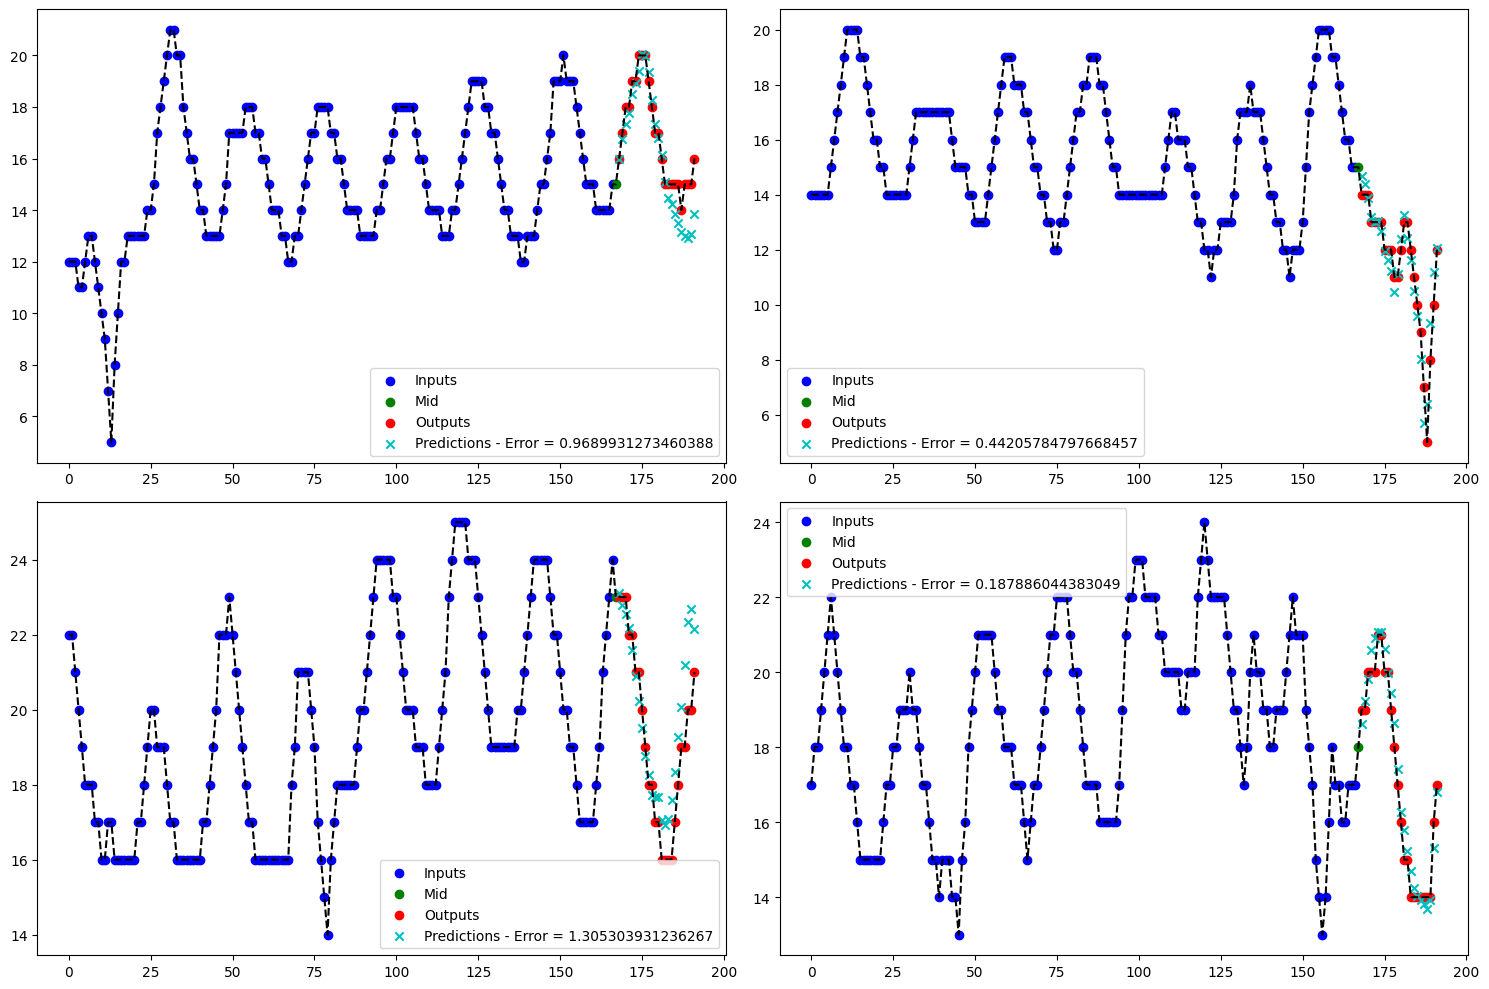

In [44]:
# Reload the model
# (Seeding for reproducibility)
def visualize_some_predictions(model, dataloader):
    fig, axs = plt.subplots(2, 2, figsize = (15, 10))
    
    index1 = 2486
    ax = axs[0, 0]
    torch.manual_seed(index1)
    torch.cuda.manual_seed(index1)
    torch.cuda.manual_seed_all(index1)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(index1)
    inputs1, outputs1 = next(iter(dataloader))
    inputs1 = inputs1.unsqueeze(-1).permute(1, 0, 2)
    outputs1 = outputs1.unsqueeze(-1).permute(1, 0, 2)

    pred1 = model(inputs1)
    inputs1, outputs1, mid1 = inputs1.detach().cpu().numpy()[:-1, 64], outputs1.detach().cpu().numpy()[:, 64], inputs1[-1, 64].unsqueeze(0).detach().cpu().numpy()
    pred1 = pred1.detach().cpu().numpy()[:, 64]
    times1 = [i for i in range(len(inputs1))]
    times2 = [len(inputs1)]
    times3 = [len(inputs1) + i + 1 for i in range(len(outputs1))]
    ax.scatter(times1, inputs1, label = "Inputs", c = "b")
    ax.scatter(times2, mid1, label = "Mid", c = "g")
    ax.scatter(times3, outputs1, label = "Outputs", c = "r")
    err = np.mean((outputs1 - pred1)**2)
    ax.scatter(times3, pred1, label = "Predictions - Error = {}".format(err), c = "c", marker = "x")
    ax.plot(times1 + times2 + times3, np.concatenate([inputs1, mid1, outputs1]),  "k--")
    ax.legend(loc = "best")

    index1 = 2986
    ax = axs[0, 1]
    torch.manual_seed(index1)
    torch.cuda.manual_seed(index1)
    torch.cuda.manual_seed_all(index1)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(index1)
    inputs1, outputs1 = next(iter(dataloader))
    inputs1 = inputs1.unsqueeze(-1).permute(1, 0, 2)
    outputs1 = outputs1.unsqueeze(-1).permute(1, 0, 2)
    pred1 = model(inputs1)
    inputs1, outputs1, mid1 = inputs1.detach().cpu().numpy()[:-1, 64], outputs1.detach().cpu().numpy()[:, 64], inputs1[-1, 64].unsqueeze(0).detach().cpu().numpy()
    pred1 = pred1.detach().cpu().numpy()[:, 64]
    times1 = [i for i in range(len(inputs1))]
    times2 = [len(inputs1)]
    times3 = [len(inputs1) + i + 1 for i in range(len(outputs1))]
    ax.scatter(times1, inputs1, label = "Inputs", c = "b")
    ax.scatter(times2, mid1, label = "Mid", c = "g")
    ax.scatter(times3, outputs1, label = "Outputs", c = "r")
    err = np.mean((outputs1 - pred1)**2)
    ax.scatter(times3, pred1, label = "Predictions - Error = {}".format(err), c = "c", marker = "x")
    ax.plot(times1 + times2 + times3, np.concatenate([inputs1, mid1, outputs1]),  "k--")
    ax.legend(loc = "best")

    index1 = 3486
    ax = axs[1, 0]
    torch.manual_seed(index1)
    torch.cuda.manual_seed(index1)
    torch.cuda.manual_seed_all(index1)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(index1)
    inputs1, outputs1 = next(iter(dataloader))
    inputs1 = inputs1.unsqueeze(-1).permute(1, 0, 2)
    outputs1 = outputs1.unsqueeze(-1).permute(1, 0, 2)
    pred1 = model(inputs1)
    inputs1, outputs1, mid1 = inputs1.detach().cpu().numpy()[:-1, 64], outputs1.detach().cpu().numpy()[:, 64], inputs1[-1, 64].unsqueeze(0).detach().cpu().numpy()
    pred1 = pred1.detach().cpu().numpy()[:, 64]
    times1 = [i for i in range(len(inputs1))]
    times2 = [len(inputs1)]
    times3 = [len(inputs1) + i + 1 for i in range(len(outputs1))]
    ax.scatter(times1, inputs1, label = "Inputs", c = "b")
    ax.scatter(times2, mid1, label = "Mid", c = "g")
    ax.scatter(times3, outputs1, label = "Outputs", c = "r")
    err = np.mean((outputs1 - pred1)**2)
    ax.scatter(times3, pred1, label = "Predictions - Error = {}".format(err), c = "c", marker = "x")
    ax.plot(times1 + times2 + times3, np.concatenate([inputs1, mid1, outputs1]),  "k--")
    ax.legend(loc = "best")

    index1 = 3986
    ax = axs[1, 1]
    torch.manual_seed(index1)
    torch.cuda.manual_seed(index1)
    torch.cuda.manual_seed_all(index1)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(index1)
    inputs1, outputs1 = next(iter(dataloader))
    inputs1 = inputs1.unsqueeze(-1).permute(1, 0, 2)
    outputs1 = outputs1.unsqueeze(-1).permute(1, 0, 2)
    pred1 = model(inputs1)
    inputs1, outputs1, mid1 = inputs1.detach().cpu().numpy()[:-1, 64], outputs1.detach().cpu().numpy()[:, 64], inputs1[-1, 64].unsqueeze(0).detach().cpu().numpy()
    pred1 = pred1.detach().cpu().numpy()[:, 64]
    times1 = [i for i in range(len(inputs1))]
    times2 = [len(inputs1)]
    times3 = [len(inputs1) + i + 1 for i in range(len(outputs1))]
    ax.scatter(times1, inputs1, label = "Inputs", c = "b")
    ax.scatter(times2, mid1, label = "Mid", c = "g")
    ax.scatter(times3, outputs1, label = "Outputs", c = "r")
    err = np.mean((outputs1 - pred1)**2)
    ax.scatter(times3, pred1, label = "Predictions - Error = {}".format(err), c = "c", marker = "x")
    ax.plot(times1 + times2 + times3, np.concatenate([inputs1, mid1, outputs1]),  "k--")
    ax.legend(loc = "best")

    plt.tight_layout()
    plt.show()
    
hidden_size = 64
seq2seq_model = Seq2Seq(hidden_size = hidden_size, \
                        output_size = n_outputs).to(device)
seq2seq_model.load_state_dict(torch.load('seq2seq_model_end.pth'))
# Visualize
visualize_some_predictions(seq2seq_model, pt_dataloader)

Epoch 1/1051, Avg Loss: 313.4691925048828
Epoch 26/1051, Avg Loss: 14.143695449829101
Epoch 51/1051, Avg Loss: 1.3270741820335388
Epoch 76/1051, Avg Loss: 0.5843719780445099
Epoch 101/1051, Avg Loss: 0.420777490735054
Epoch 126/1051, Avg Loss: 0.41964144110679624
Epoch 151/1051, Avg Loss: 0.4103161424398422
Epoch 176/1051, Avg Loss: 0.33963876962661743
Epoch 201/1051, Avg Loss: 0.30975601077079773
Epoch 226/1051, Avg Loss: 0.28160427808761596
Epoch 251/1051, Avg Loss: 0.25212488770484925
Epoch 276/1051, Avg Loss: 0.23337429910898208
Epoch 301/1051, Avg Loss: 0.20425500422716142
Epoch 326/1051, Avg Loss: 0.18620397299528121
Epoch 351/1051, Avg Loss: 0.16375356316566467
Epoch 376/1051, Avg Loss: 0.14060610681772232
Epoch 401/1051, Avg Loss: 0.1296512745320797
Epoch 426/1051, Avg Loss: 0.11205932721495629
Epoch 451/1051, Avg Loss: 0.09821809902787208
Epoch 476/1051, Avg Loss: 0.09080497995018959
Epoch 501/1051, Avg Loss: 0.08237537816166877
Epoch 526/1051, Avg Loss: 0.07195386216044426
Ep

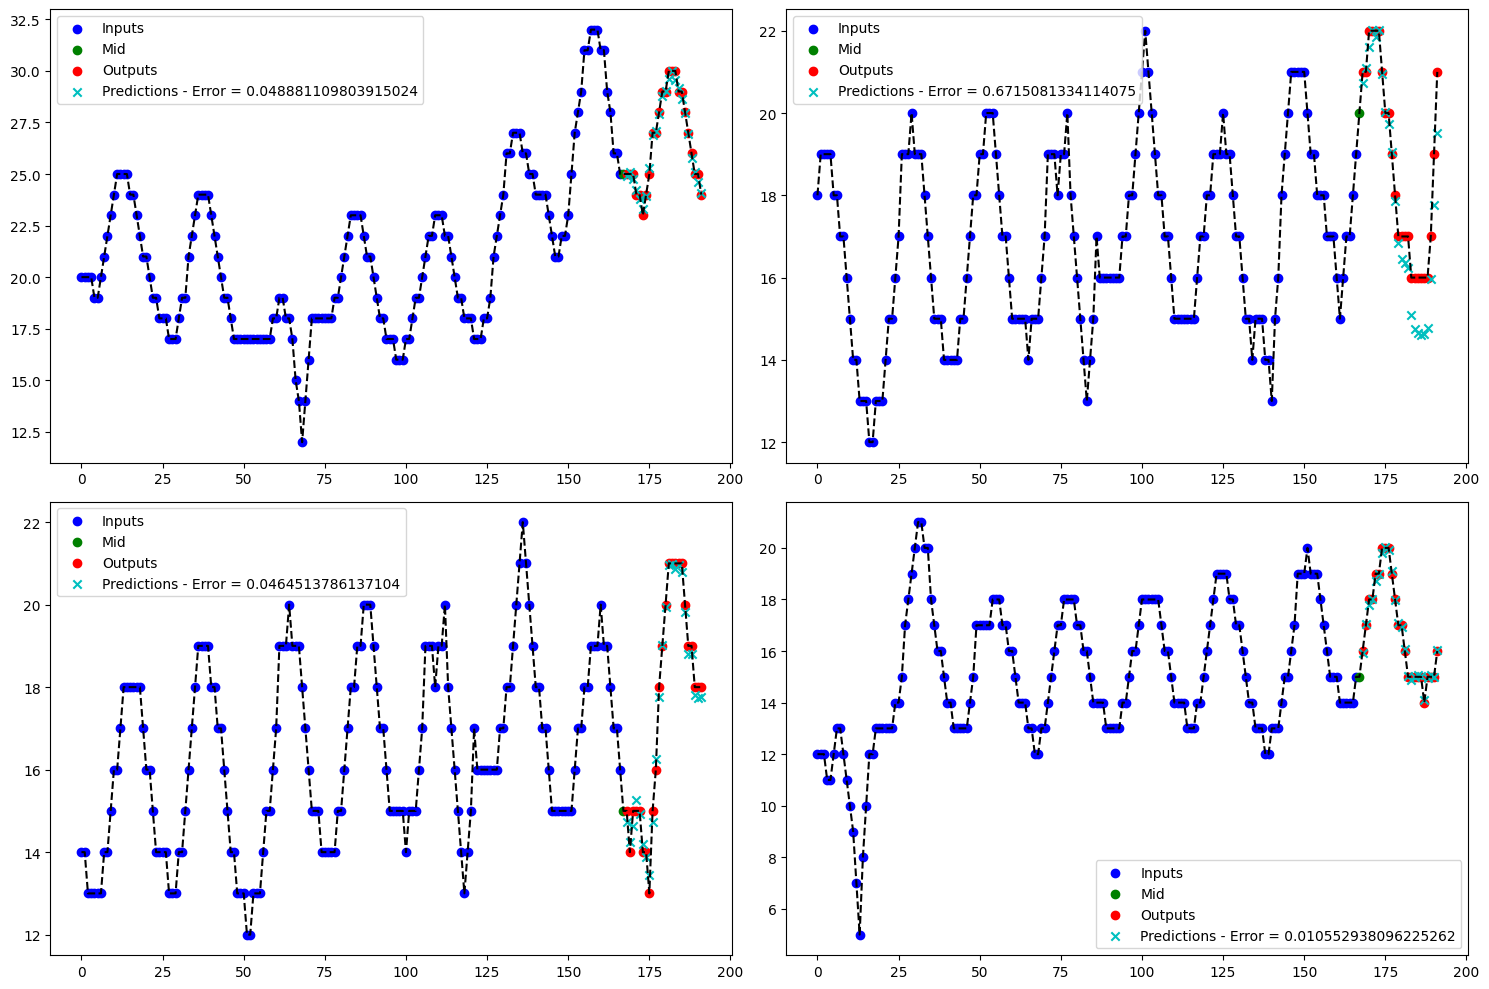

In [46]:
# 1: Experimentation by using larger hidden size of 256

hidden_size_2 = 256
seq2seq_model = Seq2Seq(hidden_size = hidden_size_2, \
                        output_size = n_outputs).to(device)
%timeit -r 1 -n 1 train(dataloader = pt_dataloader, model = seq2seq_model, num_epochs = 1051, learning_rate = 1e-3)

test_model(seq2seq_model, pt_dataloader, seed_value)
# Visualize
visualize_some_predictions(seq2seq_model, pt_dataloader)

Epoch 1/1051, Avg Loss: 17.03724412918091
Epoch 26/1051, Avg Loss: 1.355266535282135
Epoch 51/1051, Avg Loss: 0.23243684470653533
Epoch 76/1051, Avg Loss: 0.17442743480205536
Epoch 101/1051, Avg Loss: 0.15764141976833343
Epoch 126/1051, Avg Loss: 0.129928520321846
Epoch 151/1051, Avg Loss: 0.11695384234189987
Epoch 176/1051, Avg Loss: 0.10587147176265717
Epoch 201/1051, Avg Loss: 0.08771288245916367
Epoch 226/1051, Avg Loss: 0.08007529601454735
Epoch 251/1051, Avg Loss: 0.07131197229027748
Epoch 276/1051, Avg Loss: 0.05717606097459793
Epoch 301/1051, Avg Loss: 0.050480029359459874
Epoch 326/1051, Avg Loss: 0.042548449337482454
Epoch 351/1051, Avg Loss: 0.03986554965376854
Epoch 376/1051, Avg Loss: 0.031375963054597375
Epoch 401/1051, Avg Loss: 0.025220449827611447
Epoch 426/1051, Avg Loss: 0.025428320094943047
Epoch 451/1051, Avg Loss: 0.020961265824735165
Epoch 476/1051, Avg Loss: 0.01722926218062639
Epoch 501/1051, Avg Loss: 0.015866447519510985
Epoch 526/1051, Avg Loss: 0.0132635508

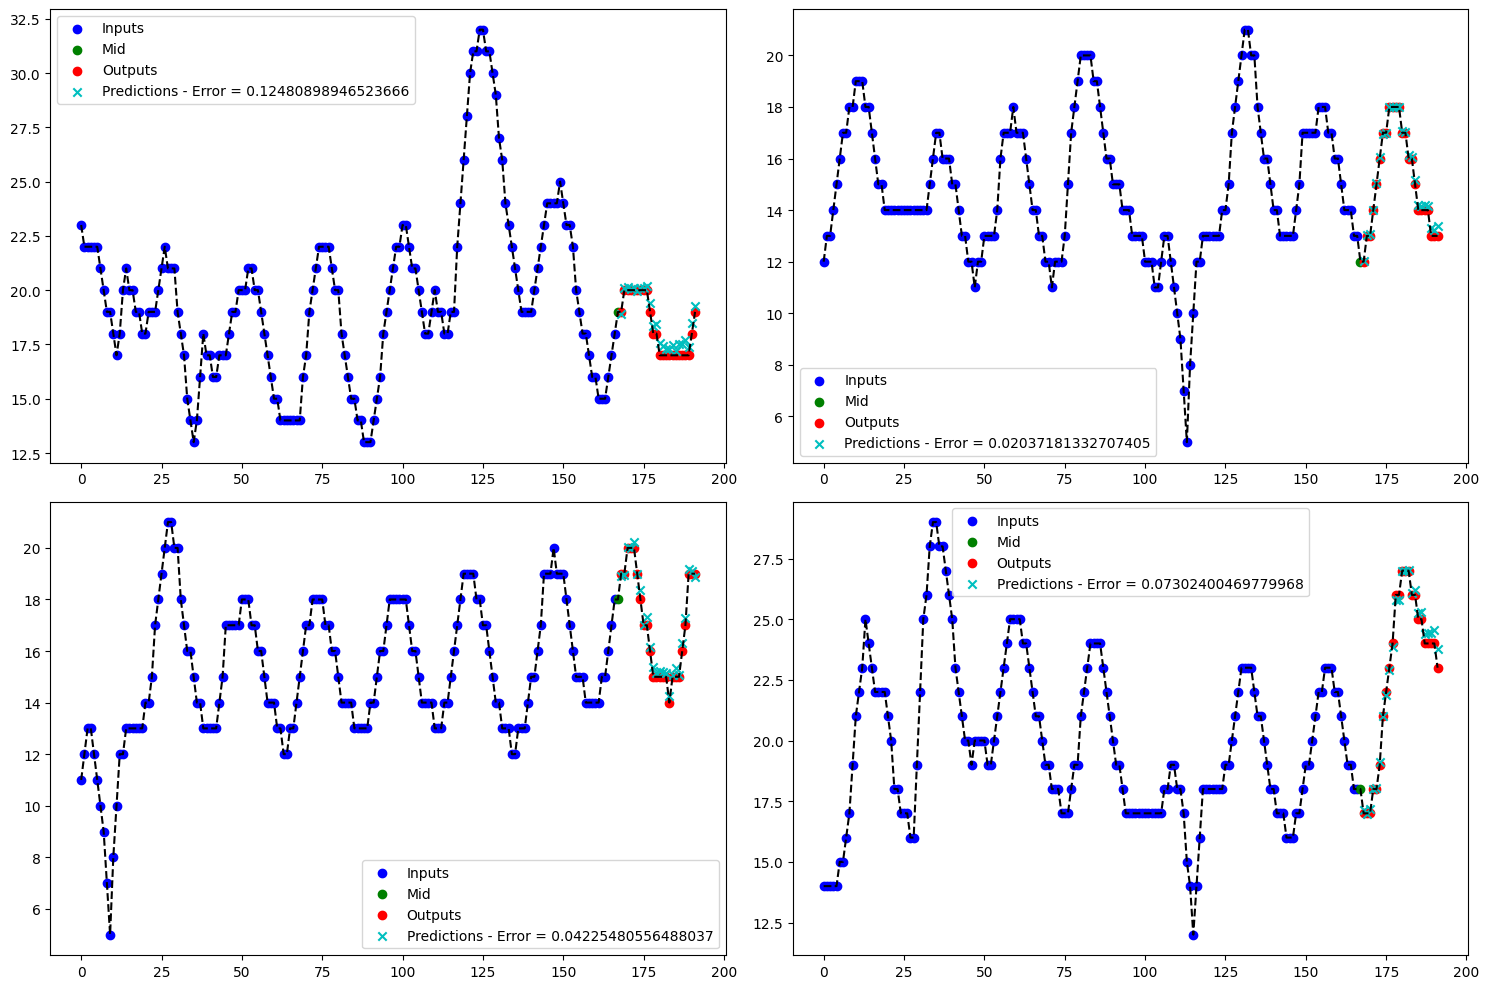

In [47]:
# 2: Experimentation by using larger hidden size of 256 & Huber Loss function 

def train_ver_2(dataloader, model, num_epochs, learning_rate):
    # Set the model to training mode
    model.train()
    criterion = nn.SmoothL1Loss() # Less sensitive to outliers than MSE, but still differentiable at 0.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, outputs in dataloader:
            inputs = inputs.to(device)
            outputs = outputs.to(device)
            inputs = inputs.unsqueeze(-1).permute(1, 0, 2)
            outputs = outputs.unsqueeze(-1).permute(1, 0, 2)
            # Clear previous gradients
            optimizer.zero_grad()
            # Forward pass
            pred = model(inputs, outputs)
            # Calculate loss
            loss = criterion(pred, outputs)
            total_loss += loss.item()
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Print total loss every few epochs
        if epoch % 25 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Avg Loss: {total_loss / len(dataloader)}')

hidden_size_2 = 256
seq2seq_model = Seq2Seq(hidden_size = hidden_size_2, \
                        output_size = n_outputs).to(device)
%timeit -r 1 -n 1 train_ver_2(dataloader = pt_dataloader, model = seq2seq_model, num_epochs = 1051, learning_rate = 1e-3)

test_model(seq2seq_model, pt_dataloader, seed_value)
# Visualize
visualize_some_predictions(seq2seq_model, pt_dataloader)

Epoch 1/1051, Avg Loss: 374.4299072265625
Epoch 26/1051, Avg Loss: 49.81527099609375
Epoch 51/1051, Avg Loss: 20.465597343444824
Epoch 76/1051, Avg Loss: 11.86431884765625
Epoch 101/1051, Avg Loss: 6.731345748901367
Epoch 126/1051, Avg Loss: 4.2814635038375854
Epoch 151/1051, Avg Loss: 2.993851137161255
Epoch 176/1051, Avg Loss: 2.241154372692108
Epoch 201/1051, Avg Loss: 1.763524580001831
Epoch 226/1051, Avg Loss: 1.4063746571540832
Epoch 251/1051, Avg Loss: 1.1191502928733825
Epoch 276/1051, Avg Loss: 0.9251863360404968
Epoch 301/1051, Avg Loss: 0.7800311863422393
Epoch 326/1051, Avg Loss: 0.6622300773859024
Epoch 351/1051, Avg Loss: 0.5622335642576217
Epoch 376/1051, Avg Loss: 0.4973377794027328
Epoch 401/1051, Avg Loss: 0.42833873331546785
Epoch 426/1051, Avg Loss: 0.397016304731369
Epoch 451/1051, Avg Loss: 0.33883396089076995
Epoch 476/1051, Avg Loss: 0.32229329347610475
Epoch 501/1051, Avg Loss: 0.28697699010372163
Epoch 526/1051, Avg Loss: 0.2696274995803833
Epoch 551/1051, Avg

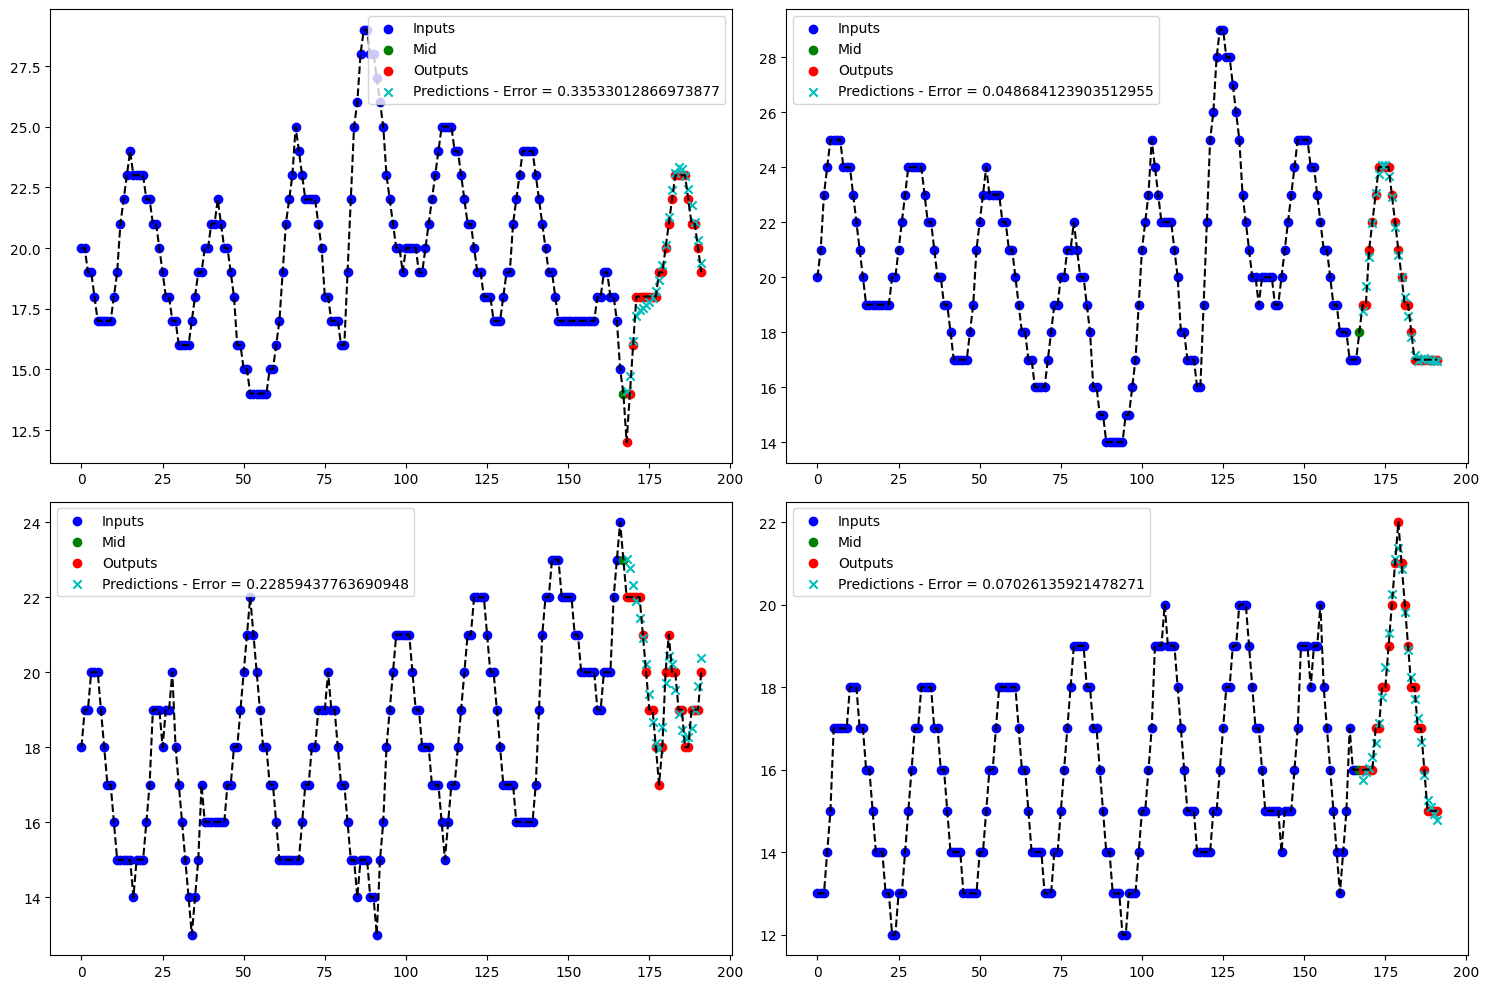

In [ ]:
# 3: Experimentation by using larger hidden size of 256 & the learning rate at 1e-4 
hidden_size_2 = 256
seq2seq_model = Seq2Seq(hidden_size = hidden_size_2, \
                        output_size = n_outputs).to(device)
%timeit -r 1 -n 1 train(dataloader = pt_dataloader, model = seq2seq_model, num_epochs = 1051, learning_rate = 1e-4)

test_model(seq2seq_model, pt_dataloader, seed_value)
# Visualize
visualize_some_predictions(seq2seq_model, pt_dataloader)

## This concludes HW3.

Do not give up, it is a feasible task! If your model does not work, most likely, you are making a mistake in the Encoder model or - most likely - the Decoder model. Take your time to think about the task at hand and the model we should use for that task.